In [1]:
import pandas as pd
import numpy as np          
import matplotlib.pyplot as plt
import seaborn as sns   
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import log

In [2]:
weather_df = pd.read_csv('cleaned_weather_data.csv')
trip_df = pd.read_csv('trip.csv')

In [3]:
# Ensure both timestamps are datetime
trip_df['start_time'] = pd.to_datetime(trip_df['start_time'])
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Sort dataframes by time (required for merge_asof)
trip_df = trip_df.sort_values('start_time')
weather_df = weather_df.sort_values('time')

# Merge to associate each trip with closest previous weather record
df = pd.merge_asof(
    trip_df,
    weather_df,
    left_on='start_time',
    right_on='time',
    direction='backward')


In [4]:
df.drop(columns=['time', 'end_time'], inplace=True)  # Drop the 'time' and 'end_time column from weather_df after merge as I don't need them anymore

In [5]:
# Create a date column from the 'start_time'
df['date'] = df['start_time'].dt.date


In [6]:
df.head()  # Check for null values


,bicycle_id,start_time,start_location,end_location,duration,route,index,temperature_C,humidity,windspeed_kph,...,temperature_bin,wind_chill_bin,humidity_bin,hour,time_of_day,month,month_str,bad_weather,severe_weather,date
0,86602,2015-01-01 00:04:00,802,508,0 days 00:06:00,802-508,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
1,86157,2015-01-01 00:04:00,802,508,0 days 00:12:00,802-508,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
2,86091,2015-01-01 00:08:00,513,1106,0 days 00:24:00,513-1106,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
3,86908,2015-01-01 00:09:00,513,604,0 days 00:20:00,513-604,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
4,86075,2015-01-01 00:15:00,516,901,0 days 00:06:00,516-901,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01


In [7]:
trip_weather = df.copy()  # Create a copy of the merged DataFrame   
trip_weather.to_csv('root_level.csv', index=False)  # Save the merged DataFrame to a CSV file

In [8]:
df.shape

(131800, 29)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131800 entries, 0 to 131799
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   bicycle_id             131800 non-null  int64         
 1   start_time             131800 non-null  datetime64[ns]
 2   start_location         131800 non-null  int64         
 3   end_location           131800 non-null  int64         
 4   duration               131800 non-null  object        
 5   route                  131800 non-null  object        
 6   index                  131800 non-null  int64         
 7   temperature_C          131800 non-null  float64       
 8   humidity               131800 non-null  int64         
 9   windspeed_kph          131800 non-null  float64       
 10  wind_direction_degres  131800 non-null  int64         
 11  wind_direction         131800 non-null  object        
 12  pressure_mBar          131800 non-null  int6

 Aggregate & Analyze:  

- Aggregate the trip data by the chosen strategic end stations and by time.  
- Examine the weather sensitivity via regression analyses. This can involve:  
    - Comparing average trip counts under different weather conditions.  
    - Testing interactions between weather variables and time-of-day.  


### Approach: Focus on the Destination (End Station)

#### Objective:
Understanding how weather influences trips that bring riders to high-value, strategic locations (e.g., city centers, universities, parks).

#### Advantages:

1. **Actionable Insights**:  
    - Focusing on end stations allows direct assessment of which destinations are less weather-sensitive.  
    - For example, if strategic places show less reduction in trips during bad weather, it may indicate that demand is driven by necessity or strong incentives (e.g., commuting, essential activities).

2. **Simplified Analysis**:  
    - Aggregating data on a single destination dimension reduces complexity.  
    - This approach avoids variability from both start and end stations, producing clearer, more actionable results.



Step 1: Aggregate the Trip Counts by End Station
Count Trips per End Station: Identify the Most Common End Stations:
Once you have the counts, you can sort the stations and set a threshold (for example, choosing stations with at least 50 or 100 trips) to focus on those that see consistent high volume.

### Exclude Round-Trip Rides

Since trips where the start and end locations are identical (or very similar) are more likely to be recreational—and thus potentially more weather-sensitive—you want to remove them from the dataset.

In [10]:
# Exclude trips where the start and end are identical
filtered_df = df[df['start_location'] != df['end_location']].copy()

# Inspect the resulting DataFrame
filtered_df.head()
print("Total trips before filtering:", len(df))
print("Total trips after filtering:", len(filtered_df))

Total trips before filtering: 131800
Total trips after filtering: 121475


In [ ]:
# Count trips per end_location and sort in descending order
end_trip_counts = filtered_df['end_location'].value_counts().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False)

# Display the top 10 most common end stations
end_trip_counts.head(10)

,end_location,trip_count
0,1304,3855
1,905,3852
2,508,3370
3,515,3139
4,611,3103
5,1301,2983
6,517,2960
7,609,2957
8,607,2922
9,1101,2882


Combine With Station Metadata  
Why Combine?  
**Contextual Information:**  
Our analysis can gain insights into station importance using station capacity (`num_of_rack`) and geographic location (`lat`, `lng`).  

**Filtering or Grouping:**  
We may use capacity to focus on stations that can support high usage or map the stations to identify those in a city center versus those in peripheral areas.

In [12]:
# Load station data
station_df = pd.read_csv('unique_station_data.csv', parse_dates=['datetime_start', 'datetime_end'])

# Merge the station metadata with your filtered trip data:
# We'll merge on the destination: end_location in filtered_df matches place_id in station_df
merged_df = pd.merge(
    filtered_df,
    station_df,
    left_on='end_location',
    right_on='place_id',
    how='left',
)

# Inspect the merge
merged_df.head()

,bicycle_id,start_time,start_location,end_location,duration,route,index,temperature_C,humidity,windspeed_kph,...,bad_weather,severe_weather,date,place_id,place_name,lat,lng,num_of_rack,datetime_start,datetime_end
0,86602,2015-01-01 00:04:00,802,508,0 days 00:06:00,802-508,0,-12.0,85,5.6,...,0,0,2015-01-01,508,Erzsébet tér,47.499101,19.054499,16.0,2015-01-01 00:00:01,2015-05-31 23:55:03
1,86157,2015-01-01 00:04:00,802,508,0 days 00:12:00,802-508,0,-12.0,85,5.6,...,0,0,2015-01-01,508,Erzsébet tér,47.499101,19.054499,16.0,2015-01-01 00:00:01,2015-05-31 23:55:03
2,86091,2015-01-01 00:08:00,513,1106,0 days 00:24:00,513-1106,0,-12.0,85,5.6,...,0,0,2015-01-01,1106,Budafoki út - Schönherz Kollégium,47.473265,19.052653,32.0,2015-01-01 00:00:01,2015-05-31 23:55:03
3,86908,2015-01-01 00:09:00,513,604,0 days 00:20:00,513-604,0,-12.0,85,5.6,...,0,0,2015-01-01,604,Kodály körönd,47.509295,19.069101,18.0,2015-01-01 00:00:01,2015-05-31 23:55:03
4,86075,2015-01-01 00:15:00,516,901,0 days 00:06:00,516-901,0,-12.0,85,5.6,...,0,0,2015-01-01,901,Markusovszky tér,47.486404,19.065662,15.0,2015-01-01 00:00:01,2015-05-31 23:55:03


In [13]:
end_trip_counts = merged_df['end_location'].value_counts().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False)

# Display the top 10 most common end stations
end_trip_counts.head()

,end_location,trip_count
0,905,3651
1,508,3099
2,611,2993
3,515,2889
4,609,2804


In [14]:
common_end_stations = end_trip_counts.head(10)['end_location'].tolist()
common_end_stations 

[905, 508, 611, 515, 609, 1301, 1304, 607, 517, 1101]

In [15]:
min_capacity = station_df['num_of_rack'].quantile(0.75)
print(f"75th percentile capacity: {min_capacity}")

# Filter to high-capacity ("strategic") stations
strategic_stations = merged_df[merged_df['num_of_rack'] >= min_capacity]

75th percentile capacity: 22.0


In [16]:
# 4. Create the strategic common stations DataFrame by selecting stations that are both common and strategic
strategic_common_stations = strategic_stations[strategic_stations['place_id'].isin(common_end_stations)]
strategic_common_stations.head() 

,bicycle_id,start_time,start_location,end_location,duration,route,index,temperature_C,humidity,windspeed_kph,...,bad_weather,severe_weather,date,place_id,place_name,lat,lng,num_of_rack,datetime_start,datetime_end
20,86513,2015-01-01 01:12:00,707,609,0 days 00:15:00,707-609,2,-10.0,86,3.7,...,0,0,2015-01-01,609,Andrássy út - Nagymező utca,47.503428,19.060796,22.0,2015-01-01 00:00:01,2015-05-31 23:55:03
35,86243,2015-01-01 02:12:00,514,517,0 days 00:16:00,514-517,4,-9.0,79,0.0,...,0,0,2015-01-01,517,Városháza Park,47.497068,19.055121,25.5,2015-01-01 00:00:01,2015-05-31 23:55:03
36,86759,2015-01-01 02:12:00,514,517,0 days 00:16:00,514-517,4,-9.0,79,0.0,...,0,0,2015-01-01,517,Városháza Park,47.497068,19.055121,25.5,2015-01-01 00:00:01,2015-05-31 23:55:03
37,87030,2015-01-01 02:12:00,514,517,0 days 00:16:00,514-517,4,-9.0,79,0.0,...,0,0,2015-01-01,517,Városháza Park,47.497068,19.055121,25.5,2015-01-01 00:00:01,2015-05-31 23:55:03
40,86366,2015-01-01 02:14:00,1103,905,0 days 00:11:00,1103-905,4,-9.0,79,0.0,...,0,0,2015-01-01,905,Kálvin tér,47.489731,19.061387,30.0,2015-01-01 00:00:01,2015-05-31 23:55:03


In [17]:
df = strategic_common_stations.copy()  # Create a copy of the merged DataFrame

In [18]:
df.groupby(['end_location', 'start_time']).size().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False) 

,end_location,start_time,trip_count
4779,517,2015-05-31 01:29:00,7
608,515,2015-02-28 12:42:00,6
19063,1304,2015-04-19 13:40:00,6
7986,609,2015-03-09 09:38:00,5
19832,1304,2015-05-17 18:37:00,5
...,...,...,...
7213,609,2015-01-08 11:13:00,1
7212,609,2015-01-08 11:12:00,1
7211,609,2015-01-08 09:49:00,1
7210,609,2015-01-08 08:54:00,1


In [19]:
def time_of_day(hour):
    '''Segments the hour into different times of the day
       Morning: 6-12, Afternoon: 12-17, Evening: 17-21, Night: 21-5'''
    if 6 <= hour < 9:
        return 'Morning Rush Hour'   
    if 9 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Early Afternoon'
    elif 16 <= hour < 18:
        return 'Afternoon Rush Hour'
    elif 18 <= hour < 21:
        return 'Evening'
    elif 21 <= hour < 24:
        return 'Night'
    else:
        return 'Late Night'

In [20]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['time_of_day'] = df['start_time'].dt.hour.apply(time_of_day)

In [21]:
df['weekend'] = df['start_time'].dt.dayofweek.apply(lambda x: 1 if x in [5, 6] else 0)

In [22]:
df.drop(columns=['bicycle_id', 'num_of_rack', 'wind_chill_bin'], inplace=True)  # Drop unnecessary columns

In [23]:
df.dtypes

start_time               datetime64[ns]
start_location                    int64
end_location                      int64
duration                         object
route                            object
index                             int64
temperature_C                   float64
humidity                          int64
windspeed_kph                   float64
wind_direction_degres             int64
wind_direction                   object
pressure_mBar                     int64
visibility_km                   float64
wind_chill_C                    float64
fog                               int64
rain                              int64
snow                              int64
thunder                           int64
temperature_bin                  object
humidity_bin                     object
hour                              int64
time_of_day                      object
month                             int64
month_str                        object
bad_weather                       int64


### Aggregate Trip Data by Station, Date, and Time of Day

In [24]:
agg_df = df.groupby(['place_id', 'place_name', 'date', 'time_of_day']).agg(
  # Temperature: daily average, max, and min
    avg_temp=('temperature_C', 'mean'),
    max_temp=('temperature_C', 'max'),
    min_temp=('temperature_C', 'min'),
    
    # Other continuous variables
    avg_humidity=('humidity', 'mean'),
    avg_windspeed=('windspeed_kph', 'mean'),
    avg_pressure=('pressure_mBar', 'mean'),
    pressure_change=('pressure_mBar', lambda x: x.max() - x.min()),
    avg_visibility=('visibility_km', 'mean'),
    
    # Binary or count variables: use sum
    rain_half_hours=('rain', 'sum'),
    snow_half_hours=('snow', 'sum'),
    thunder_half_hours=('thunder', 'sum'),
    fog_half_hours=('fog', 'sum'),
    bad_weather_half_hours=('bad_weather', 'sum'),
    severe_weather_half_hours=('severe_weather', 'sum'),
    
    trip_count=('start_time', 'count'), # Count of trips, our target variable

    # Categorical variables: use mode (most common value)
    predominant_temperature_bin=('temperature_bin', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    month=('month', 'last'),
    month_str=('month_str', 'last'),
    weekend=('weekend', 'last'),
).reset_index()

In [25]:
agg_df.head()

,place_id,place_name,date,time_of_day,avg_temp,max_temp,min_temp,avg_humidity,avg_windspeed,avg_pressure,...,snow_half_hours,thunder_half_hours,fog_half_hours,bad_weather_half_hours,severe_weather_half_hours,trip_count,predominant_temperature_bin,month,month_str,weekend
0,515,Fővám tér,2015-01-01,Afternoon Rush Hour,-3.0,-3.0,-3.0,72.333333,8.633333,1034.666667,...,1,0,0,0,1,3,Very Cold,1,Jan,0
1,515,Fővám tér,2015-01-01,Early Afternoon,-3.0,-3.0,-3.0,64.000000,9.300000,1034.000000,...,0,0,0,0,0,1,Very Cold,1,Jan,0
2,515,Fővám tér,2015-01-01,Late Night,-8.0,-8.0,-8.0,79.000000,3.700000,1036.000000,...,0,0,0,0,0,1,Very Cold,1,Jan,0
3,515,Fővám tér,2015-01-02,Afternoon Rush Hour,0.0,0.0,0.0,87.000000,5.600000,1027.000000,...,0,0,0,0,0,2,Cold,1,Jan,0
4,515,Fővám tér,2015-01-02,Early Afternoon,1.0,1.0,1.0,81.000000,7.400000,1027.000000,...,0,0,0,0,0,1,Cold,1,Jan,0


In [26]:
df['place_id'].unique()

array([ 609,  517,  905,  611,  515, 1304,  607, 1101], dtype=int64)

In [27]:
agg_df.shape

(5002, 23)

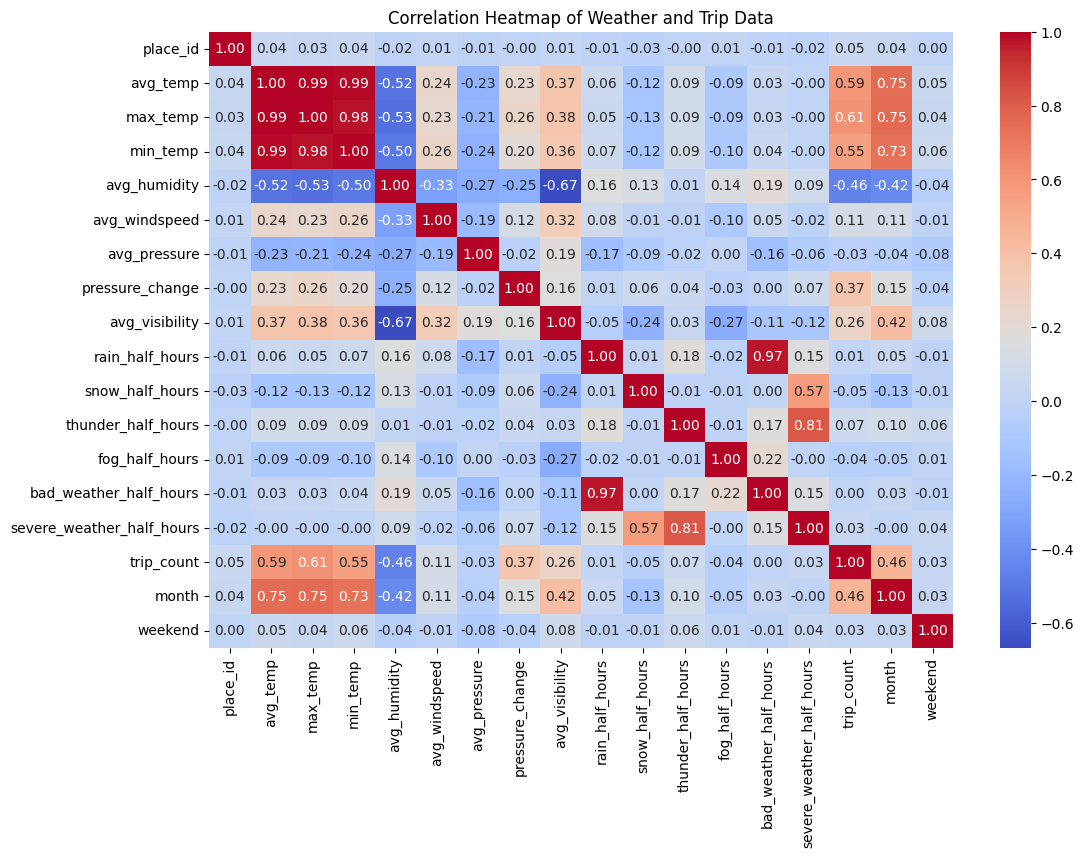

In [28]:
numeric_columns = agg_df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap( numeric_columns.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Weather and Trip Data')
plt.show()

In [29]:
agg_df['trip_count'].describe()

count    5002.000000
mean        4.624550
std         4.590987
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        43.000000
Name: trip_count, dtype: float64

<Axes: >

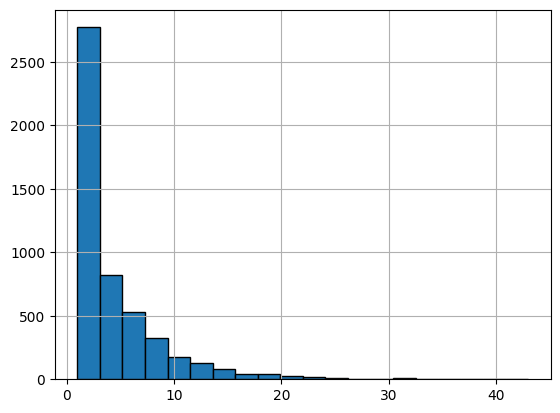

In [30]:
agg_df['trip_count'].hist(bins=20, edgecolor='black')

the data is clearly positively skewed with many low counts, which is common in count data:
A Negative Binomial regression is a strong, appropriate choice because it explicitly models skewed, discrete count data and accommodates overdispersion (variance > mean).


## Negative Binomial Assumptions
- Dependent Variable (Y) is Count data: Clearly satisfied (trip counts).
- Observations are independent:
Assumed satisfied as you aggregated by day, time_of_day, and place (no obvious dependence within groups).
- Overdispersion (variance > mean):
The Negative Binomial model is designed specifically for cases where count data exhibit overdispersion.

In [31]:
print('Mean:', agg_df['trip_count'].mean())
print('Variance:', agg_df['trip_count'].var())

Mean: 4.624550179928029
Variance: 21.077165614458075


**Strong evidence of overdispersion**

### Linearity in Log Link

- **Definition**: The log-linear relationship between predictors and the expected count.
- **Robustness**: Count models are typically robust to mild non-linearity.
- **Visual Checks**:
    - Partial regression plots.
    - Residual plots.

In [32]:
zero_proportion = (agg_df['trip_count'] == 0).mean()
print('Zero proportion:', zero_proportion)

Zero proportion: 0.0


### Negative Binomial Regression

In [33]:
# Creating a new column for the lagged trip count 
agg_df['trip_count_lag1'] = agg_df['trip_count'].shift(1)

# Dropping the first row if it introduces a NaN value due to lagging
agg_df = agg_df.dropna(subset=['trip_count_lag1'])

In [34]:
agg_df.columns

Index(['place_id', 'place_name', 'date', 'time_of_day', 'avg_temp', 'max_temp',
       'min_temp', 'avg_humidity', 'avg_windspeed', 'avg_pressure',
       'pressure_change', 'avg_visibility', 'rain_half_hours',
       'snow_half_hours', 'thunder_half_hours', 'fog_half_hours',
       'bad_weather_half_hours', 'severe_weather_half_hours', 'trip_count',
       'predominant_temperature_bin', 'month', 'month_str', 'weekend',
       'trip_count_lag1'],
      dtype='object')

<Figure size 1500x1000 with 0 Axes>

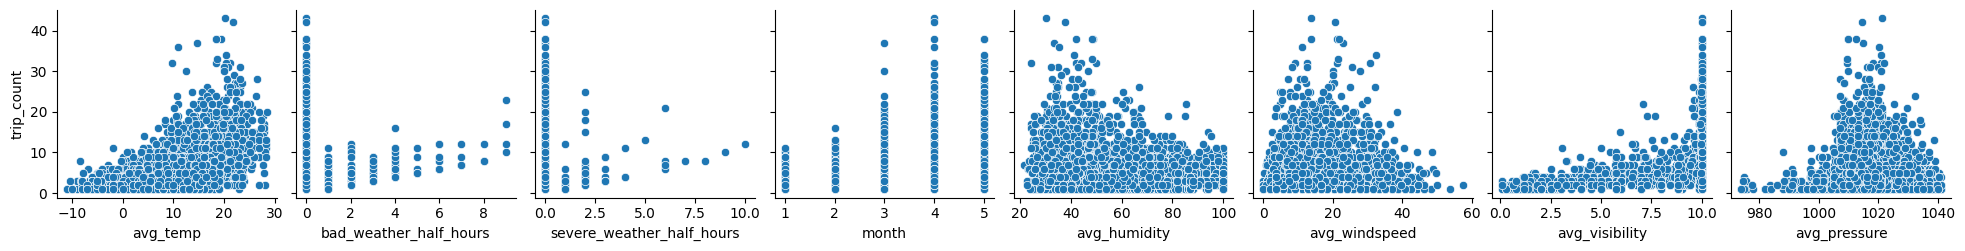

In [35]:
plt.figure(figsize=(15, 10))
sns.pairplot(agg_df, x_vars=['avg_temp', 'bad_weather_half_hours', 'severe_weather_half_hours', 'month', 'avg_humidity', 'avg_windspeed', 'avg_visibility', 'avg_pressure'], y_vars='trip_count')
plt.show() # Pairplot of the features against trip_count

In [36]:
# Negative Binomial Regression Model.

nb_model = smf.glm(
    formula="trip_count ~  max_temp + avg_humidity + min_temp + avg_windspeed + pressure_change + avg_pressure + avg_visibility + \
             bad_weather_half_hours + trip_count_lag1 + \
             C(time_of_day) + C(month) + C(weekend) + C(place_id)",
    data=agg_df,
    family=sm.families.NegativeBinomial()
).fit()

# Print the summary output for details.
print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             trip_count   No. Observations:                 5001
Model:                            GLM   Df Residuals:                     4973
Model Family:        NegativeBinomial   Df Model:                           27
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12239.
Date:                Tue, 15 Apr 2025   Deviance:                       1115.7
Time:                        11:24:19   Pearson chi2:                 1.27e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3094
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

C:\Users\gsant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [37]:
# Extract coefficients and their confidence intervals
params = nb_model.params
exp_params = np.exp(params) # Exponentiating to get multiplicative effects
pvals = nb_model.pvalues 

results_df = pd.DataFrame({
    'Exp(Coefficient)': exp_params,
    'p-value': pvals})

results_df['p-value'] = results_df['p-value'].map(lambda x: '{:.4f}'.format(x))

results_df

,Exp(Coefficient),p-value
Intercept,0.019049,0.1012
C(time_of_day)[T.Early Afternoon],1.155155,0.0111
C(time_of_day)[T.Evening],0.950186,0.4089
C(time_of_day)[T.Late Night],0.790059,0.0025
C(time_of_day)[T.Morning],0.768228,0.0000
C(time_of_day)[T.Morning Rush Hour],0.627739,0.0000
C(time_of_day)[T.Night],0.827671,0.0060
C(month)[T.2],1.074837,0.1806
C(month)[T.3],1.109176,0.0872
C(month)[T.4],1.261424,0.0042


**Exp(Coefficient) Interpretation:**
- **Exp(Coef) > 1:** Positive relationship (increases trips).
- **Exp(Coef) < 1:** Negative relationship (reduces trips).
- **Exp(Coef) ≈ 1:** Little or no impact.

---

### Weather Sensitivity

**Temperature (High Sensitivity):**
- **Max Temp:**  
  - Exp = 1.210, p = 0.000  
  - 21% increase in trip counts per 1°C increase in daily maximum temperature.  
  - Indicates strong positive sensitivity.
  
- **Min Temp:**  
  - Exp = 0.856, p = 0.000  
  - 14.4% decrease in trip counts per 1°C increase in daily minimum temperature.  
  - Indicates strong negative sensitivity, possibly due to discomfort in warmer mornings/evenings.

**Humidity (Minimal Sensitivity):**
- **Avg Humidity:**  
  - Exp = 0.997, p = 0.093  
  - Effect close to 1 and statistically insignificant.  
  - Suggests minimal or no clear sensitivity to humidity.

**Wind Speed (No Sensitivity):**
- **Avg Windspeed:**  
  - Exp = 1.000, p = 0.998  
  - No effect, indicating clear insensitivity to wind speed.

**Pressure Change (Moderate Sensitivity):**
- **Pressure Change:**  
  - Exp = 1.243, p = 0.000  
  - 24.3% increase in trip counts per unit increase in pressure change (log-scale).  
  - Suggests that people bike more during periods of atmospheric volatility.

**Visibility (Not Sensitive):**
- **Avg Visibility:**  
  - Exp = 0.984, p = 0.202  
  - Statistically insignificant, implying no clear effect.

**Bad Weather Events (Rain or Fog):**
- **Bad Weather Half Hours:**  
  - Exp = 1.027, p = 0.019  
  - Small but significant 2.7% increase in trip counts during these periods.

---

## Conclusions

- **Temperature:** Has a significant effect on trip counts. However, the effect spans a wide range (-10 to 30°C), suggesting it might be more informative to analyze specific subsets (e.g., Cold/Very Cold vs. Warm/Hot).
- **Station Resilience:** The minimal sensitivity to adverse conditions like wind and humidity at strategic stations indicates some resilience.
- **Bad Weather:** The small positive effect suggests that minor bad weather does not deter biking significantly.


In [38]:
# A cursory check: Is the deviance ratio close to 1?
nb_model.deviance / nb_model.df_resid

0.22434147051726733

### Deviance Analysis

- **Deviance significantly below 1 (0.32)**: Indicates that your model has a good (possibly overly good) fit.

#### Practical Meaning:
- **Effective Model**: The Negative Binomial model effectively captures variation in the data.
- **Underdispersion (deviance < 1)**: Generally considered acceptable and less problematic then overdispertion.

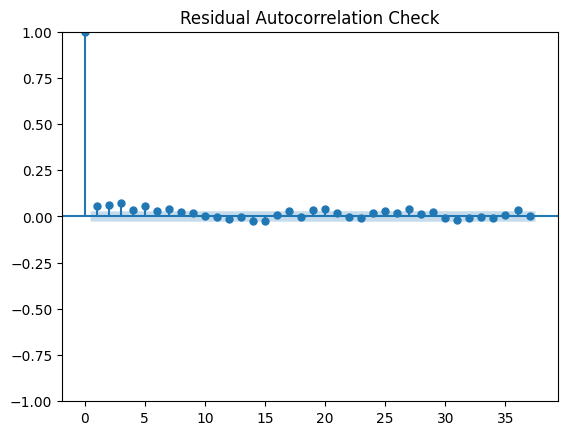

In [39]:
# Plotting the residuals
from statsmodels.graphics.tsaplots import plot_acf

# Extract residuals
agg_df['residuals'] = nb_model.resid_response

# Plot residual autocorrelation
plot_acf(agg_df['residuals'])
plt.title('Residual Autocorrelation Check')
plt.show()


### Residual Autocorrelation Analysis

- **No significant spikes beyond the first lag**: Lag 0 is always equal to 1.
- **Autocorrelation coefficients**: The blue dots are well within the confidence interval (blue band).

- **No significant autocorrelation**: The residual independence assumption holds.


### Visualization

Next Steps for Analysis:

### Visualizations:

Line or Time-Series Plots: Plot trip counts over time for each station, overlaying weather conditions (e.g., temperature, precipitation).

Boxplots: Compare distributions of trip counts for different weather conditions (e.g., “good” vs. “bad” weather) during rush versus non-rush hours for each end station.

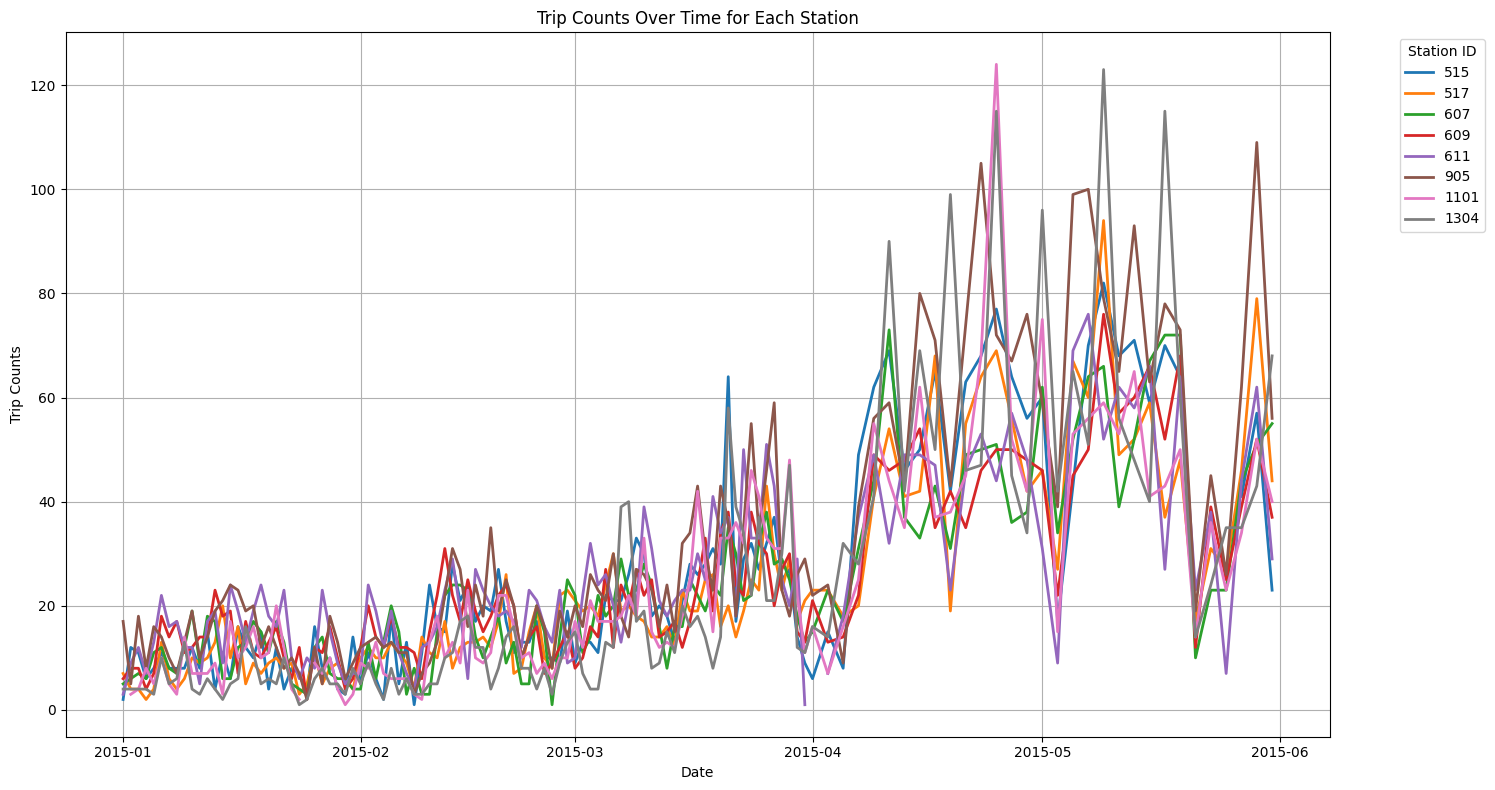

In [40]:
# Group data by date and place_id to aggregate trip counts
trip_counts_by_date = agg_df.groupby(['date', 'place_id'])['trip_count'].sum().reset_index()

# Pivot the data to have dates as rows and stations as columns
pivot_data = trip_counts_by_date.pivot(index='date', columns='place_id', values='trip_count')

# Plot the data
plt.figure(figsize=(15, 8))
pivot_data.plot(ax=plt.gca(), linewidth=2)
plt.title('Trip Counts Over Time for Each Station')
plt.xlabel('Date')
plt.ylabel('Trip Counts')
plt.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

###  Aggregated Model vs Single Stations

- When aggregating the data across the top 5 stations, the larger sample size increases statistical power, allowing subtle effects like "bad weather half hours" to emerge as significant.
- In contrast, individual station analyses have smaller sample sizes and may also be influenced by unique local factors, which can mask these effects and render them non-significant.


In [41]:
agg_df.to_csv('top_stations.csv', index=False)
# Save the results to a CSV file